In [15]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import nctoolkit as nc

from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
nc.deep_clean()

## Setup

In [3]:
# produce 1-degree grid cell areas
# read in a single GEOS Chem ouput file, regrid AREA variable with nctoolkit, and update areas
ds_area = nc.open_data(
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.SpeciesConc.20140901_0000z.nc4"
)
ds_area.subset(variables = "AREA")
ds_area.to_latlon(lon = [-179.5, 179.5], lat = [-89.5, 89.5], res = [1, 1], method="con")
ds_area.cell_area(join=False)
target_grid_area = ds_area.to_xarray()["cell_area"]
target_grid_area

<xarray.DataArray 'cell_area' (lat: 180, lon: 360)>
array([[1.078908e+08, 1.078908e+08, 1.078908e+08, ..., 1.078908e+08,
        1.078908e+08, 1.078908e+08],
       [3.236394e+08, 3.236394e+08, 3.236394e+08, ..., 3.236394e+08,
        3.236394e+08, 3.236394e+08],
       [5.392896e+08, 5.392896e+08, 5.392896e+08, ..., 5.392896e+08,
        5.392896e+08, 5.392896e+08],
       ...,
       [5.392896e+08, 5.392896e+08, 5.392896e+08, ..., 5.392896e+08,
        5.392896e+08, 5.392896e+08],
       [3.236394e+08, 3.236394e+08, 3.236394e+08, ..., 3.236394e+08,
        3.236394e+08, 3.236394e+08],
       [1.078908e+08, 1.078908e+08, 1.078908e+08, ..., 1.078908e+08,
        1.078908e+08, 1.078908e+08]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  area
    long_name:      area of grid cell
    units:          m^2

In [4]:
# dataset configuration
date_range = pd.date_range(start="2014-09", end="2017-04", freq="1M")
target_grid = xe.util.grid_global(1, 1, cf=True)
target_grid

<xarray.Dataset>
Dimensions:     (bound: 2, lon: 360, lat: 180)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bound
Data variables:
    lon_bounds  (bound, lon) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
    lat_bounds  (bound, lat) int64 -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89 90

In [5]:
def get_mozart_pressure_edges(ds):
    # compute pressure edges in units hPA; equation: https://www2.acom.ucar.edu/gcm/mozart-4
    return (ds["P0"] * ds["hyai"] + ds["PS"] * ds["hybi"]) * 0.01


def compute_pressure_weights(ds, level_name: str):
    surface_pressure = ds[level_name].max(dim="ilev")
    weights = abs(ds[level_name].diff("ilev").rename(ilev="lev") / surface_pressure)
    # levels will take the value of the minuend’s ilev coordinate, instead we need to update 
    # to the dataset's level coordinate
    weights["lev"] = ds["lev"]
    return weights

def compute_xco2(ds, mole_frac_name: str, weights_name: str):
    return (ds[mole_frac_name] * ds[weights_name]).sum(dim="lev")



## Compute pressure weighted average at first timestep for both models and map the difference

In [7]:
with xr.open_dataset(
    "../1_transport/intermediates/MOZART/output/BasisFnsUpdated/201409/"
    "BasisFnsUpdated.mz4.h0.2014-09-01-03600.nc",
    decode_times=False,
) as ds:
    ds = ds.isel(time=0)
    ds["pressure_edge"] = get_mozart_pressure_edges(ds)
    ds["pressure_weights"] = compute_pressure_weights(ds, "pressure_edge")

    ds_mozart = ds[["CO2_VMR_avrg", "pressure_weights"]]
    ds_mozart = xe.Regridder(ds_mozart, target_grid, method="conservative")(ds_mozart)

    da_mozart_xco2 = compute_xco2(ds_mozart, "CO2_VMR_avrg", "pressure_weights")
    
    

with xr.open_mfdataset(
    [
        "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
        "GEOSChem.LevelEdgeDiags.20140901_0000z.nc4",
        "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
        "GEOSChem.SpeciesConc.20140901_0000z.nc4",
    ]
) as ds:
    ds = ds.isel(time=0)
    ds["pressure_weights"] = compute_pressure_weights(ds, "Met_PEDGE")

    ds_geoschem = ds[["SpeciesConc_CO2", "pressure_weights"]]
    ds_geoschem = xe.Regridder(ds_geoschem, target_grid, method="conservative")(ds_geoschem)

    da_geoschem_xco2 = compute_xco2(ds_geoschem, "SpeciesConc_CO2", "pressure_weights")


da_xco2_diff_t0 = da_geoschem_xco2 - da_mozart_xco2
da_xco2_diff_t0

/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]


<xarray.DataArray (lat: 180, lon: 360)>
dask.array<sub, shape=(180, 360), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

Text(0.5, 1.0, 'Difference of initial XCO2: GEOS Chem minus MOZART')

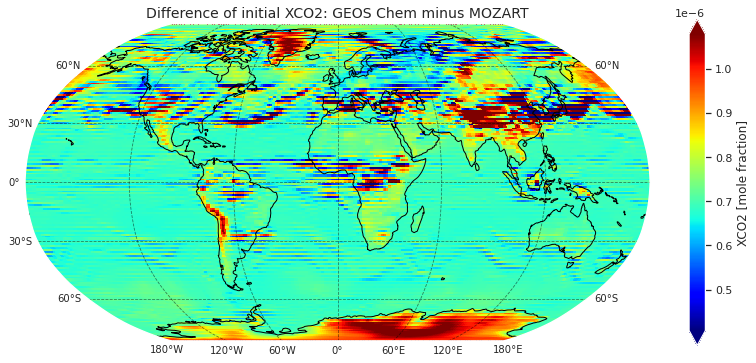

In [8]:
def prep_axes(ax):
    ax.set_global()
    ax.coastlines()
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        linewidth=0.8,
        color="black",
        alpha=0.5,
        linestyle="--",
        draw_labels=True,
    )
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER


PROJ = ccrs.Robinson()
fig, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": PROJ})
xr.plot.imshow(
    darray=da_xco2_diff_t0,
    transform=ccrs.PlateCarree(),
    ax=ax,
    cmap="jet",
    robust=True,
    cbar_kwargs={"label": "XCO2 [mole fraction]"},
)
prep_axes(ax)
ax.set_title("Difference of initial XCO2: GEOS Chem minus MOZART", fontsize=14)
# fig.savefig(f"../plots/{filename}.png", dpi=180)

## Suface analyses

In [6]:
mozart_paths = []
for month in date_range:
    yyyy, mm, _ = str(month).split("-")
    mozart_paths.append(
        f"../1_transport/intermediates/MOZART/output/BasisFnsUpdated/{yyyy}{mm}/"
        f"BasisFnsUpdated.mz4.h0.{yyyy}-{mm}-01-03600.nc"
    )

geoschem_spec_conc_glob = (
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.SpeciesConc.*_0000z.nc4"
)
geoschem_level_edge_glob = (
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.LevelEdgeDiags.*_0000z.nc4"
)

### Hovmoller diagrams

In [7]:
## produce surface level datasets of monthly longitudinal averages (5 min compute time)

with xr.open_dataset(mozart_paths[0], decode_times=False) as ds:
    # precompute mozart grid weights
    regridder_mozart = xe.Regridder(ds[["CO2_VMR_avrg"]], target_grid, "conservative")

def prep_mozart(ds):
    ds["time"] = pd.to_datetime(ds.date.values, format="%Y%m%d") + pd.to_timedelta(
        ds.datesec.values, unit="seconds"
    )
    # surface level is the LAST element along the lev dimension
    ds_co2 = ds[["CO2_VMR_avrg"]].isel(lev=-1)
    return regridder_mozart(ds_co2).mean(dim="lon")

with xr.open_mfdataset(
    mozart_paths,
    preprocess=prep_mozart,
    parallel=True,
    decode_times=False,
) as ds:
    da_mozart_co2_hov = ds["CO2_VMR_avrg"].resample(time="1M").mean().drop("lev")


with xr.open_dataset(
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.SpeciesConc.20140901_0000z.nc4"
) as ds:
    # precompute geos chem grid weights
    regridder_geoschem = xe.Regridder(ds[["SpeciesConc_CO2"]], target_grid, "conservative")

def prep_geoschem(ds):
    # surface level is the FIRST element along the lev dimension
    ds_co2 = ds[["SpeciesConc_CO2"]].isel(lev=0)
    return regridder_geoschem(ds_co2).mean(dim="lon")

with xr.open_mfdataset(geoschem_spec_conc_glob, preprocess=prep_geoschem, parallel=True) as ds:
    ds = ds.where(ds["time"] <= da_mozart_co2_hov.time.values.max(), drop=True)
    da_geoschem_co2_hov = ds["SpeciesConc_CO2"].resample(time="1M").mean().drop("lev")

da_surface_hov_diff = (da_geoschem_co2_hov - da_mozart_co2_hov).compute();

/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]


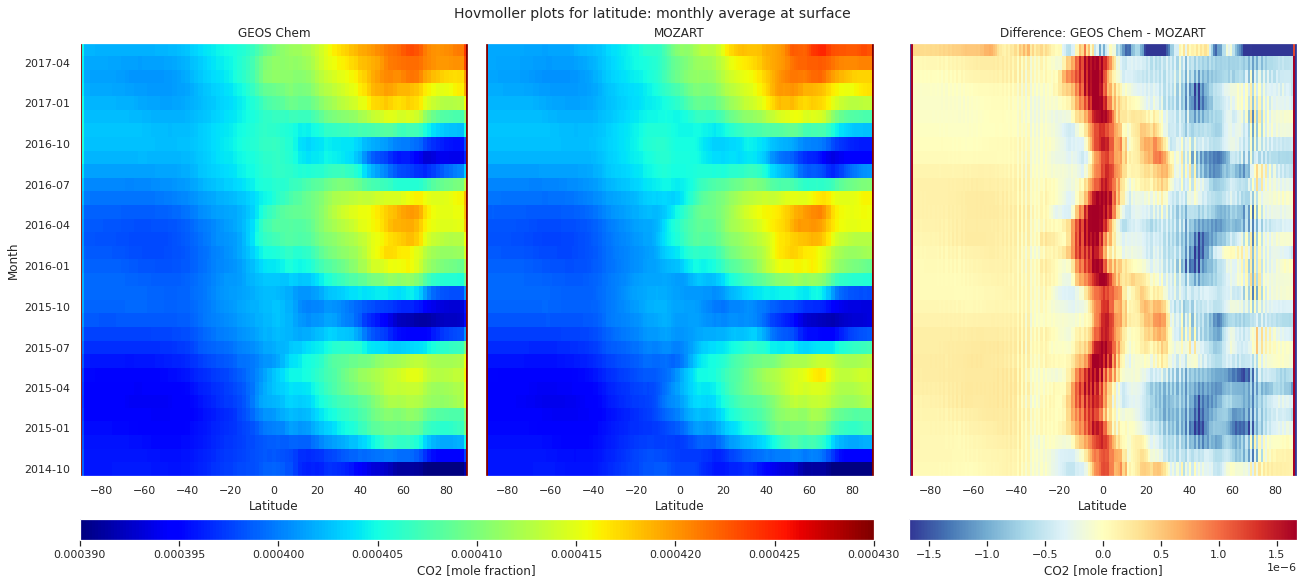

In [23]:
fig = plt.figure(figsize=(18, 8), constrained_layout=True)

gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 0.05])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
main_cbar_ax = fig.add_subplot(gs[1, :2])
diff_cbar_ax = fig.add_subplot(gs[1, 2])

vmin, vmax = 39e-5, 43e-5
sub_geoschem = da_geoschem_co2_hov.plot(
    ax=ax1, vmin=vmin, vmax=vmax, cmap="jet", add_colorbar=False
)
sub_mozart = da_mozart_co2_hov.plot(
    ax=ax2, vmin=vmin, vmax=vmax, cmap="jet", add_colorbar=False
)
fig.colorbar(
    sub_geoschem, cax=main_cbar_ax, orientation="horizontal", label="CO2 [mole fraction]"
)

sub_diff = da_surface_hov_diff.plot(ax=ax3, robust=True, cmap="RdYlBu_r", add_colorbar=False)
fig.colorbar(sub_diff, cax=diff_cbar_ax, orientation="horizontal", label="CO2 [mole fraction]")

ax1.set_title("GEOS Chem", fontsize=12)
ax1.set_ylabel("Month", fontsize=12)
ax2.set_title("MOZART", fontsize=12)
ax2.set_ylabel(None)
plt.setp(ax2.get_yticklabels(), visible=False)
ax3.set_title("Difference: GEOS Chem - MOZART", fontsize=12)
ax3.set_ylabel(None)
plt.setp(ax3.get_yticklabels(), visible=False)
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("Latitude", fontsize=12)

fig.suptitle("Hovmoller plots for latitude: monthly average at surface", fontsize=14);


### Time series of global (area weighted) averages

## Vertical column analyses (pressure weighted column average)

In [11]:
# precompute grid weights
    
with xr.open_dataset(
    "../1_transport/intermediates/MOZART/output/BasisFnsUpdated/201409/"
    "BasisFnsUpdated.mz4.h0.2014-09-01-03600.nc",
    decode_times=False,
) as ds:
    ds["pressure_edge"] = get_mozart_pressure_edges(ds)
    ds["pressure_weights"] = compute_pressure_weights(ds["pressure_edge"])
    print(ds)
#     regridder_mozart = xe.Regridder(
#         ds[["CO2_VMR_avrg", "pressure_edge"]], target_grid, "conservative"
#     )

# with xr.open_mfdataset(
#     [
#         "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
#         "GEOSChem.LevelEdgeDiags.20140901_0000z.nc4",
#         "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
#         "GEOSChem.SpeciesConc.20140901_0000z.nc4",
#     ]
# ) as ds:
#     regridder_geoschem = xe.Regridder(
#         ds[["SpeciesConc_CO2", "Met_PEDGE"]], target_grid, "conservative"
#     )


<xarray.Dataset>
Dimensions:                (lev: 56, ilev: 57, lat: 96, lon: 144, time: 720)
Coordinates:
  * lev                    (lev) float32 1.868 2.353 2.948 ... 962.5 977.5 992.5
  * ilev                   (ilev) float32 1.651 2.085 2.62 ... 970.0 985.0 1e+03
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                   (time) float64 7.358e+05 7.358e+05 ... 7.359e+05
Data variables: (12/72)
    P0                     float32 ...
    ntrm                   int32 ...
    ntrn                   int32 ...
    ntrk                   int32 ...
    ndbase                 int32 ...
    nsbase                 int32 ...
    ...                     ...
    CO2_T19_SRF_EMIS_avrg  (time, lat, lon) float32 ...
    CO2_T20_SRF_EMIS_avrg  (time, lat, lon) float32 ...
    CO2_T21_SRF_EMIS_avrg  (time, lat, lon) float32 ...
    CO2_T22_SRF_EMIS_avrg  (time, lat, lon) float32 

In [10]:
# demo subset
mozart_paths =[
    "../1_transport/intermediates/MOZART/output/BasisFnsUpdated/201409/"
    "BasisFnsUpdated.mz4.h0.2014-09-01-03600.nc",
    "../1_transport/intermediates/MOZART/output/BasisFnsUpdated/201410/"
    "BasisFnsUpdated.mz4.h0.2014-10-01-03600.nc"
]

def prep_mozart(ds):
    # setup times correctly
    ds["time"] = pd.to_datetime(ds["date"].values, format="%Y%m%d") + pd.to_timedelta(
        ds["datesec"].values, unit="seconds"
    )
    # compute pressure edges (in units hPA)
    ds["pressure_edge"] = get_mozart_pressure_edges(ds)

    # format according to GEOS Chem conventions
    # ds_mozart = ds_mozart.reindex(ilev=ds_mozart.ilev[::-1])
    # ds_mozart = ds_mozart.transpose("time", "ilev", "lev", "lat", "lon")

    # compute pressure deltas
    ds["pressure_weights"] = compute_pressure_weights(ds["pressure_edge"])
    ds_mozart = ds[["CO2_VMR_avrg", "pressure_weights"]]

     # shift longitude coordinate reference
    ds_mozart["lon"] = ds_mozart["lon"] - 180.0

    # regrid to 1x1 degree
    ds_mozart = regridder_mozart(ds_mozart)
    ds_mozart["area"] = target_grid_area

    return ds_mozart
    

ds_mozart = xr.open_mfdataset(mozart_paths, preprocess=prep_mozart, parallel=True, decode_times=False)
    

# one observation for every hour of every day in study period, in units VMR, regridded
ds_mozart


<xarray.Dataset>
Dimensions:        (time: 1464, lev: 56, y: 180, x: 360, ilev: 57, lon: 360,
                    lat: 180)
Coordinates:
  * ilev           (ilev) float32 1.651 2.085 2.62 3.276 ... 970.0 985.0 1e+03
  * lev            (lev) float32 1.868 2.353 2.948 3.677 ... 962.5 977.5 992.5
  * time           (time) datetime64[ns] 2014-09-01T01:00:00 ... 2014-11-01
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: y, x
Data variables:
    CO2_VMR_avrg   (time, lev, y, x) float32 dask.array<chunksize=(720, 56, 180, 360), meta=np.ndarray>
    pressure_edge  (ilev, time, y, x) float32 dask.array<chunksize=(57, 720, 180, 360), meta=np.ndarray>
    area           (time, lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08
Attributes:
    regrid_method:  conservative

In [5]:
# mozart_datetime_end = ds_mozart.time.values.max()

# # geoschem_level_edge_glob = (
# #     "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
# #     "GEOSChem.LevelEdgeDiags.*_0000z.nc4"
# # )
# geoschem_level_edge_glob = [
#     "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
#     "GEOSChem.LevelEdgeDiags.20140901_0000z.nc4",
#     "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
#     "GEOSChem.LevelEdgeDiags.20140902_0000z.nc4"
# ]
# with xr.open_mfdataset(geoschem_level_edge_glob) as ds:
#     da_pressure_level = ds["Met_PEDGE"]

# geoschem_spec_conc_glob = (
#     "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
#     "GEOSChem.SpeciesConc.*_0000z.nc4"
# )
geoschem_glob = [
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.LevelEdgeDiags.20140901_0000z.nc4",
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.LevelEdgeDiags.20140902_0000z.nc4",
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.SpeciesConc.20140901_0000z.nc4",
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.SpeciesConc.20140902_0000z.nc4"
]
# def extract_co2_variable(ds):
#     return ds[["SpeciesConc_CO2"]]

# with xr.open_mfdataset(geoschem_spec_conc_glob, preprocess=extract_co2_variable) as ds_geoschem:
#     ds_geoschem["Met_PEDGE"] = da_pressure_level
#     # clip to available mozart date range
#     ds_geoschem = ds_geoschem.where(ds_geoschem["time"] <= mozart_datetime_end, drop=True)
#     # regrid to 1x1 degree
#     ds_geoschem = xe.Regridder(ds_geoschem, target_grid, "conservative")(ds_geoschem)
#     ds_geoschem["area"] = target_grid_area

ds_geoschem=xr.open_mfdataset(geoschem_glob)

# one observation for every hour of every day in study period, in units mole per mole dry, regridded
ds_geoschem

,Array,Chunk
Bytes,256.78 GiB,278.83 MiB
Shape,"(22632, 47, 180, 360)","(24, 47, 180, 360)"
Count,7820 Tasks,943 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,262.24 GiB,284.77 MiB
Shape,"(22632, 48, 180, 360)","(24, 48, 180, 360)"
Count,7820 Tasks,943 Chunks
Type,float32,numpy.ndarray
